# Criação do banco de dados simulado para o Technee Banco Safra
### Equipe 5 - Safra Hackers

#### Link para download do dataset original:
#### https://www.kaggle.com/ntnu-testimon/paysim1


### 1. Importação de Pacotes

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from math import sqrt

sns.set()

### 2. Classes e funções

In [2]:
def convert_amount(row):
    """ Função para tornar negativos valores de saída da conta"""
    op_type = row["type"]
    # Apenas o tipo CASH_IN debita valores da conta
    out_op_types = ["CASH_IN"]
    amount = row["amount"]
    row["amount"] = -amount if op_type in out_op_types else amount
   
    return row


def old_balance_fix(data):
    """ Função para correção do dataset. A informação de saldo vem 
    em alguns casos"""
    # Para correção, precisamos olhar o saldo final do dia anterior
    # Saldo final do dia anterior = Saldo inicial do dia seguinte
    
    # Necessário ordenar o dataset por conta e período para o 
    # iloc[index - 1] coletar o dia anterios daquela conta específica
    
    data = data.sort_values(["nameDest", "time_refer"])
    instances_qtd = len(data)
    
    for index in range(instances_qtd):
        row = data.iloc[index]
        if row["oldbalanceDest"] == 0.00 and row["time_refer"] != 1:
            prev_balance = data.iloc[index - 1]
            data.loc[(model_data['nameDest'] == row['nameDest']) & (model_data['oldbalanceDest'] == 0.00), "newbalanceDest"] = row["newbalanceDest"] + prev_balance["newbalanceDest"]
            data.loc[(model_data['nameDest'] == row['nameDest']) & (model_data['oldbalanceDest'] == 0.00), "oldbalanceDest"] = prev_balance["newbalanceDest"]
        elif row["oldbalanceDest"] == 0.00 and row["time_refer"] == 1:
            data.loc[(model_data['nameDest'] == row['nameDest']) & (model_data['oldbalanceDest'] == 0.00), "oldbalanceDest"] = 1.00
    return data


def calculate_wcss(data):
    """ Ajustar diversos K-means e coletar o valor
    da inércia de todos ajustes."""
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss
    
    
def get_best_number_clusters(wcss):
    """Traçar uma reta virtual entre os extremos da curva
    da inércia e calcular o N mais se aproxima dessa reta"""
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
    

def pipeline(_x_train, n):
    """ Treino e plot de um modelo baseado em algoritmo
    kmeans"""
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('kmeans', KMeans(n_clusters=n, random_state=42))])

    pipe.fit(_x_train)
    return pipe




### 3. Leitura da Dataset coletado

In [3]:
file_name = 'PS_20174392719_1491204439457_log.csv'
fin_data = pd.read_csv(file_name)
fin_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 4. Removendo as fraudes

In [4]:
fin_data = fin_data[fin_data['isFraud']==0]

#### Os emissores dos pagamentos não são significativos, são sempre únicos nesse dataset:

In [5]:
qty_rows = len(fin_data)
qty_orig = len(fin_data['nameOrig'].unique())

print(f"Qtd de instâncias = {qty_rows}")
print(f"Qtd de emissores únicos = {qty_orig}")     

Qtd de instâncias = 6354407
Qtd de emissores únicos = 6345122


#### Os nomes de conta destino já tem contas com mais de uma transferência, 
#### podemos agrupar esse público:

In [6]:
qty_dest = len(fin_data['nameDest'].unique())

print(f"Qtd de instâncias = {qty_rows}")
print(f"Qtd de destinatários únicos = {qty_dest}")   

Qtd de instâncias = 6354407
Qtd de destinatários únicos = 2719685


### 5. Agrupando a quantidade de transferências pela "conta destino" do dataset

In [7]:
fin_data['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
              ... 
M1267226562      1
M739734955       1
M1045305081      1
M1282079022      1
M1121799148      1
Name: nameDest, Length: 2719685, dtype: int64

In [8]:
dest_counts = fin_data['nameDest'].value_counts()

### 2.2 Milhões das amostras são de contas que receberam somente 1 transferência em todo dataset
#### Não é interessante usar dados de contas com poucas transferências

In [9]:
dest_counts.value_counts().head(10)

1     2260777
2       76818
3       57210
4       45030
5       36770
6       30396
7       25760
8       21901
9       18605
10      16310
Name: nameDest, dtype: int64

### 6. Tipos de transação

In [10]:
fin_data['type'].drop_duplicates()

0       PAYMENT
9         DEBIT
15     CASH_OUT
19     TRANSFER
389     CASH_IN
Name: type, dtype: object

### 7.Vendo perfil das contas que tem mais transferências

In [11]:
dest_counts[:10]

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C1590550415    101
C248609774     101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: nameDest, dtype: int64

#### 1205 contas tem pelo menos 50 transferências:

In [12]:
print("Qtd de contas com mais de 50 transferências: ",
      dest_counts[dest_counts>=50].shape[0])


Qtd de contas com mais de 50 transferências:  1205


### 8. Selecionando contas com mais de 50 transferências e filtrando as colunas

In [13]:
top_accounts = dest_counts[dest_counts>=50].index
model_data = fin_data[fin_data['nameDest'].isin(top_accounts)]



In [14]:
# Colunas para manter no dataset
col_keep = ['step', 'nameDest','type','amount',
            'oldbalanceDest','newbalanceDest']
model_data = model_data[col_keep]

In [15]:
# Separação do que é tipo de operação de entrada na conta (positivo)
# e saída (negativo)

in_operations =  ["TRANSFER", "PAYMENT", "CASH_OUT", "DEBIT"]
out_operations = ["CASH_IN"]

# Convertendo valores de saída para negativos,ajustando coluna de newbalanceDest
# que contém erros, criando uma refência temporal como se cada transação fosse
# realizada no dia seguinte, e criação da coluna da variação do valor da conta
# após a operação.

model_data = model_data.apply(convert_amount, axis=1)
model_data["newbalanceDest"] = model_data["oldbalanceDest"] + model_data["amount"]
model_data['time_refer'] = model_data.groupby("nameDest").cumcount() + 1
model_data = old_balance_fix(model_data)
model_data["relative_delta"] = model_data["amount"] / model_data["oldbalanceDest"]

# Agrupamento de operações em "IN"/OUT
model_data.loc[model_data['type'].isin(in_operations), "type"] = "IN"
model_data.loc[model_data['type'].isin(out_operations), "type"] = "OUT"

### 9. Cliente exemplo do dataset final:

In [16]:
model_data[model_data["nameDest"] == 'C791710001']

,step,nameDest,type,amount,oldbalanceDest,newbalanceDest,time_refer,relative_delta
36056,9,C791710001,IN,511470.23,1.00,511470.23,1,511470.230000
48490,9,C791710001,IN,76350.53,511470.23,587820.76,2,0.149277
49362,9,C791710001,IN,351629.45,587820.76,939450.21,3,0.598192
51708,9,C791710001,IN,931502.64,939450.21,1870952.85,4,0.991540
55481,9,C791710001,OUT,-180909.67,1870952.85,1690043.18,5,-0.096694
61787,9,C791710001,IN,250802.32,1690043.18,1940845.50,6,0.148400
72804,10,C791710001,IN,25479.50,1940845.51,1966325.01,7,0.013128
75019,10,C791710001,IN,42438.41,1966325.01,2008763.42,8,0.021583
84179,10,C791710001,IN,283176.56,2008763.42,2291939.98,9,0.140971
94812,10,C791710001,OUT,-226339.80,2291939.98,2065600.18,10,-0.098755


In [17]:
model_data[model_data["nameDest"] == 'C997608398']

,step,nameDest,type,amount,oldbalanceDest,newbalanceDest,time_refer,relative_delta
10,1,C997608398,IN,9644.94,10845.00,20489.94,1,0.889344
781,1,C997608398,IN,345698.98,20489.94,366188.92,2,16.871644
807,1,C997608398,IN,1741.24,366188.92,367930.16,3,0.004755
861,1,C997608398,IN,155122.86,367930.17,523053.03,4,0.421610
925,1,C997608398,IN,251241.14,523053.03,774294.17,5,0.480336
1360,1,C997608398,IN,286803.50,774294.17,1061097.67,6,0.370406
1395,1,C997608398,IN,70543.76,1061097.67,1131641.43,7,0.066482
1706,1,C997608398,OUT,-235362.23,1128757.61,893395.38,8,-0.208514
1718,1,C997608398,OUT,-532111.14,893395.39,361284.25,9,-0.595605
1854,1,C997608398,IN,63557.19,361284.25,424841.44,10,0.175920


### 10. Visualizações temporais do saldo da conta, maiores operações 
### financeiras e variação do patrimônio

<AxesSubplot:xlabel='time_refer'>

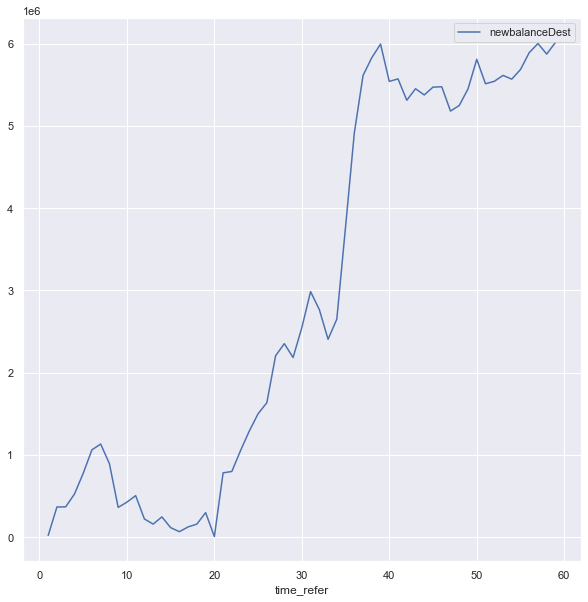

In [18]:
example_instance = model_data[model_data["nameDest"] == 'C997608398']
example_instance.plot(x='time_refer', 
                      y="newbalanceDest", 
                      figsize=(10, 10))

<AxesSubplot:xlabel='time_refer'>

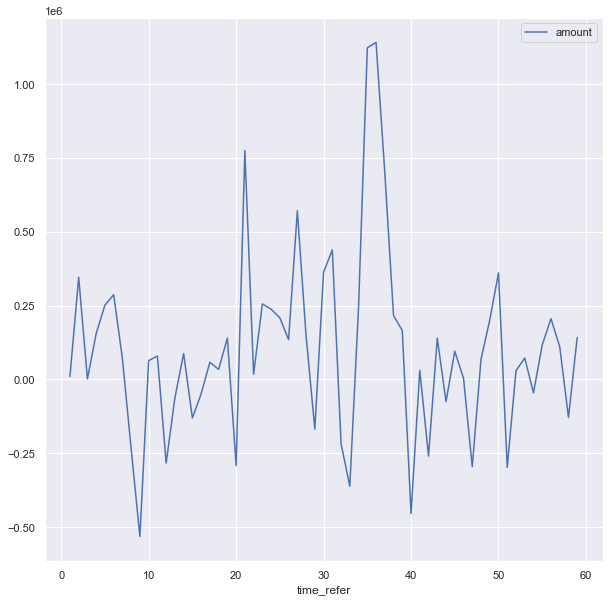

In [19]:
example_instance.plot(x='time_refer', 
                      y="amount",        
                      figsize=(10, 10))

<AxesSubplot:xlabel='time_refer'>

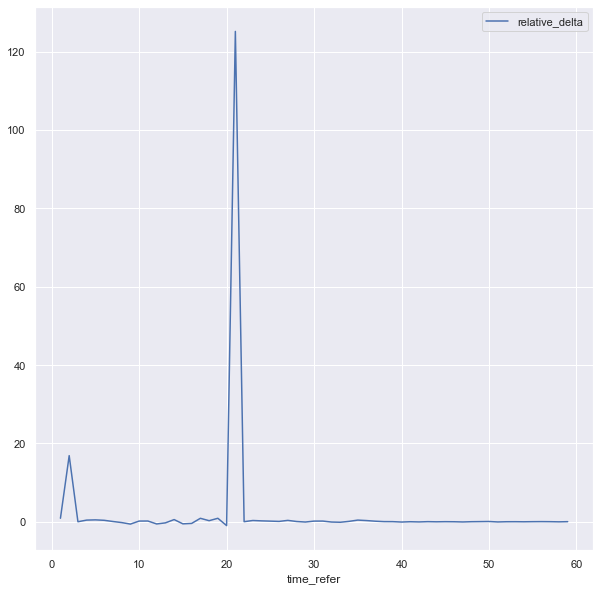

In [20]:
example_instance.plot(x='time_refer', 
                      y="relative_delta", 
                      figsize=(10, 10))

### 11. Criação do dataset final para modelagem, separando em treino e teste:

In [21]:
# Agrupamento de todas as features em entrada e saída de dinheiro (IN/OUT)
agrup_model_data = model_data.groupby(['nameDest', 'type', ]).sum().unstack()

In [22]:
# Split de 90% no treino e 10% no teste
train_data = agrup_model_data[:int(len(agrup_model_data)*0.9)]
test_data = agrup_model_data[int(len(agrup_model_data)*0.9):]

print(train_data.shape[0])
print(test_data.shape[0])

1084
121


In [23]:
train_data.head()

step             amount             oldbalanceDest                \
type           IN   OUT           IN         OUT             IN           OUT   
nameDest                                                                        
C1001367899  2970  1417   8746361.82 -2149206.59   1.307882e+08  4.320168e+07   
C1003872245  3358  1673   9553125.31 -3091279.96   1.123380e+08  5.851853e+07   
C1005928818  4086  1056  41442634.93 -2600426.09   3.081006e+08  7.496590e+07   
C1013700132  3899   808  23042271.18 -4054614.81   5.150695e+08  1.667069e+08   
C1014154376  2630  1520  20376736.03 -3572398.57   5.376672e+08  3.220407e+08   

            newbalanceDest               time_refer      relative_delta  \
type                    IN           OUT         IN  OUT             IN   
nameDest                                                                  
C1001367899   1.395345e+08  4.105247e+07       1045  333      11.189560   
C1003872245   1.218911e+08  5.542725e+07       1116  537      10.983665   
C1005928818   3.492879e+08  7.236548e+07       1205  335      31.612169   
C1013700132   5.381118e+08  1.626523e+08       1954  602       5.617376   
C1014154376   5.580440e+08  3.184683e+08        925  560       1.498432   

                       
type              OUT  
nameDest               
C1001367899 -1.750264  
C1003872245 -1.816247  
C1005928818 -3.558262  
C1013700132 -1.283702  
C1014154376 -0.634383

### 12. Modelagem (k-means)

Kmeans é um modelo não supervisionado que inicia K centróides aleatórios no
espaço amostral. Na primeira interação, é medido quais as instâncias do 
dataset de treino mais se aproximam desses pontos gerados. Após esse
cálculo, os centróides são reposicionados para a posição central dos pontos
mais próximos. Esse flxo é executado até a convergência total do modelo 
ou determinação do usuário

In [24]:
# Conversão dos números de saída para positivo (facilitar a visualização)
# Ajuste de escalas para sintetizar o dataset de acordo com a API
x_train = train_data[[ ('amount', 'OUT'), ('amount', 'IN')]]
x_train[('amount', 'OUT')] = x_train[('amount', 'OUT')]*-0.001
x_train[('amount', 'IN')] = x_train[('amount', 'IN')]*0.0001

c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
# Normalização dos dados para análise do joelho
ss = StandardScaler()
x_train_scale = ss.fit_transform(x_train)

In [26]:
inertia_scores = calculate_wcss(x_train_scale)

<AxesSubplot:>

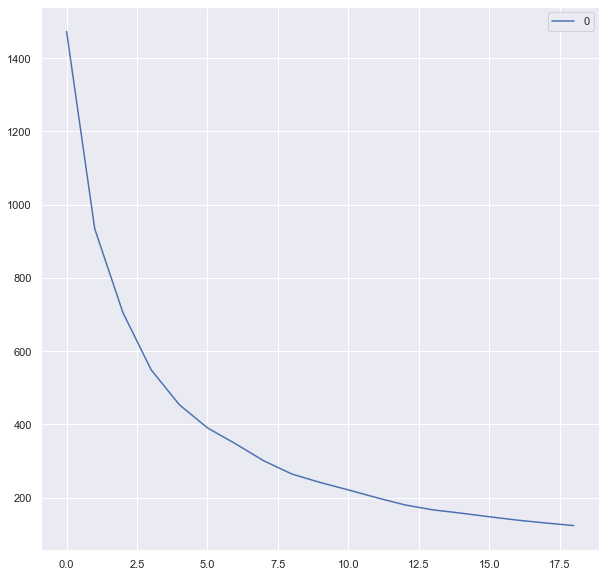

In [27]:
pd.DataFrame(inertia_scores).plot(figsize=(10, 10))

In [28]:
# Dimensionamento do melhor K
n = get_best_number_clusters(inertia_scores)
print(f"Número de Cluster = {n}")

Número de Cluster = 6


In [29]:
# Dicionário de cores + pipeline do modelo
cdict = {0: '#F7DEDC', 
         1: '#FF4040', 
         2: '#B58E41', 
         3: '#FF8080',
         4: '#C9AF6D', 
         5: '#FFBFBF'}

ldict = {0: 'Neutro',
        1: 'Risco iminente de inadimplência',
        2: 'Investidor',
        3: 'Risco de inadimplência 2',
        4: 'Possível investidor',
        5: 'Risco de inadimplência 1'}
    
model = pipeline(x_train, 
               6)

c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Valor total de saídas (R$)')

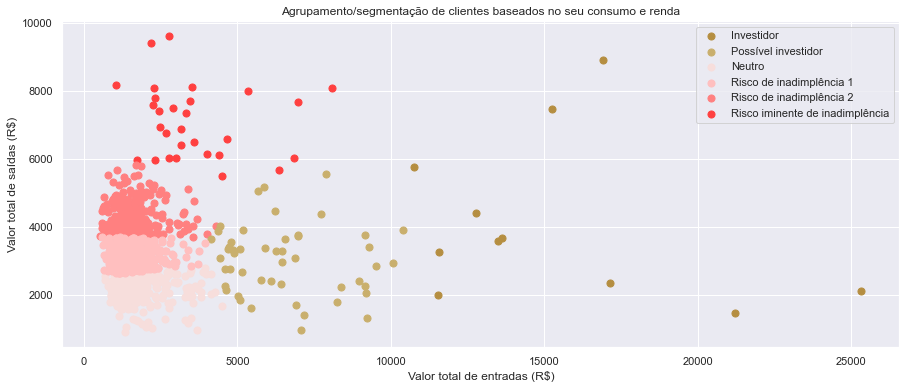

In [30]:
x_train['kmeans'] = model.predict(x_train)

group = np.array([0, 1, 2, 3, 4, 5])

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
for g in group:
    ax.scatter(x_train[('amount', 'IN')].loc[x_train['kmeans']==g], 
                     x_train[('amount', 'OUT')].loc[x_train['kmeans']==g], 
                     c=cdict[g], 
                     s=50, 
                     label=ldict[g]
                    )

handles, labels = ax.get_legend_handles_labels()

handles = [handles[2], handles[4], handles[0], handles[5], handles[3], handles[1]]
labels = [labels[2], labels[4], labels[0], labels[5], labels[3], labels[1]]

ax.legend(handles, labels, loc=1)
#plt.legend()


ax.set_title('Agrupamento/segmentação de clientes baseados no seu consumo e renda')
ax.set_xlabel('Valor total de entradas (R$)')
ax.set_ylabel('Valor total de saídas (R$)')

In [31]:
# Descrição dos clusters
x_train["desc_cluster"] = x_train["kmeans"].apply(lambda x: ldict[x])

c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
# Exportação do dataset de treino clusterizado
x_train.to_csv("sample_cluster.csv", sep=";", decimal=",", encoding="ansi")

# Teste

Classificação dos dados separados para tesste

In [33]:
test_data.head()

step             amount             oldbalanceDest                \
type          IN   OUT           IN         OUT             IN           OUT   
nameDest                                                                       
C791710001  2608  1453  13418052.44 -3334328.21   1.816722e+08  1.032864e+08   
C793116596  4601  1496  14697605.19 -3071181.72   1.328300e+08  5.258594e+07   
C794295331  2165  1147  14784001.65 -2451696.43   2.305941e+08  1.215346e+08   
C794436545  3838  2510   7608649.21 -3473114.73   9.279330e+07  5.296050e+07   
C794978521  4851  1528  14990799.88 -4412992.60   2.333199e+08  1.083008e+08   

           newbalanceDest               time_refer      relative_delta  \
type                   IN           OUT         IN  OUT             IN   
nameDest                                                                 
C791710001   1.950902e+08  9.995206e+07       1001  539  511474.682024   
C793116596   1.475276e+08  4.951476e+07        927  348       8.675915   
C794295331   2.453781e+08  1.190829e+08        984  501       3.157327   
C794436545   1.004019e+08  4.948738e+07        985  555  378170.787438   
C794978521   2.483107e+08  1.038878e+08       1050  435  187141.579387   

                       
type              OUT  
nameDest               
C791710001  -0.736008  
C793116596  -1.433395  
C794295331 -41.597096  
C794436545  -1.949954  
C794978521  -1.041572

In [34]:
# Conversão dos números de saída para positivo (facilitar a visualização)
# Ajuste de escalas para sintetizar o dataset de acordo com a API
x_test = test_data[[ ('amount', 'OUT'), ('amount', 'IN')]]
x_test[('amount', 'OUT')] = x_test[('amount', 'OUT')]*-0.001
x_test[('amount', 'IN')] = x_test[('amount', 'IN')]*0.0001

c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Valor total de saídas (R$)')

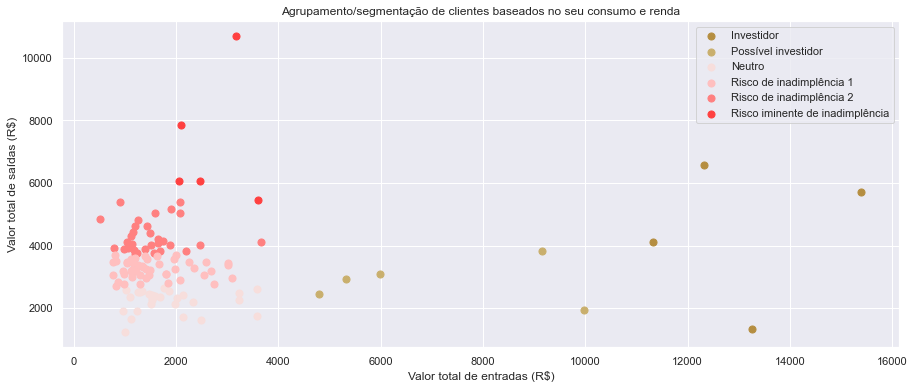

In [35]:
x_test['kmeans'] = model.predict(x_test)

group = np.array([0, 1, 2, 3, 4, 5])

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
for g in group:
    ax.scatter(x_test[('amount', 'IN')].loc[x_test['kmeans']==g], 
                     x_test[('amount', 'OUT')].loc[x_test['kmeans']==g], 
                     c=cdict[g], 
                     s=50, 
                     label=ldict[g]
                    )

handles, labels = ax.get_legend_handles_labels()

handles = [handles[2], handles[4], handles[0], handles[5], handles[3], handles[1]]
labels = [labels[2], labels[4], labels[0], labels[5], labels[3], labels[1]]

ax.legend(handles, labels, loc=1)
#plt.legend()


ax.set_title('Agrupamento/segmentação de clientes baseados no seu consumo e renda')
ax.set_xlabel('Valor total de entradas (R$)')
ax.set_ylabel('Valor total de saídas (R$)')

In [36]:
# Descrição dos clusters
x_test["desc_cluster"] = x_test["kmeans"].apply(lambda x: ldict[x])

c:\users\nicos\pycharmprojects\techneesafra_time5\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
# Exportação dos dados de teste classificados
x_test.to_csv("out_of_sample.csv", sep=";", decimal=",", encoding="ansi")

# Exportando modelo

In [38]:
import pickle

filename = 'Kmeans.sav'
pickle.dump(model, open(filename, 'wb'))

In [39]:
model_data.to_csv("model_data.csv", sep=";")